In [10]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [52]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 510)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
np.save("../data/npy/toy1_test",scaled_Phi.T)
data_path = '../data/npy/toy1.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [53]:
print(np.shape(scaled_Phi))

(127, 127, 510)


In [56]:
phi_tot=tf.expand_dims(scaled_Phi.T, axis=3)
new_phi = phi_tot[:500]
print(np.shape(new_phi))
phi_test = phi_tot[500:]

(500, 127, 127, 1)


In [44]:

y = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
   padding='valid')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([500  42  42   1], shape=(4,), dtype=int32)


In [47]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[
                  tf.keras.losses.MeanAbsoluteError() ])

    model.summary()

    history = model.fit(
            new_phi, y,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            #callbacks=get_callbacks(name),
            verbose=2)

    return history



In [48]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(42,42,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=42),
    tf.keras.layers.Reshape((42, 42, 1))
])

# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(127,127,1))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(3, 3),padding='valid')(inputs)) # + NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 average_pooling2d_10 (Avera  (None, 42, 42, 1)        0         
 gePooling2D)                                                    
                                                                 
 sequential_8 (Sequential)   (None, 42, 42, 1)         1674      
                                                                 
Total params: 1,674
Trainable params: 1,674
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 - 2s - loss: 0.2774 - mean_absolute_error: 0.4718 - val_loss: 0.3800 - val_mean_absolute_error: 0.5851 - 2s/epoch - 124ms/step
Epoch 2/500
15/15 - 0s - loss: 0.1964 - mean_absolute_error: 0.3882 - val_loss: 0.2639 - val_mean_absolute_err

In [59]:
test_true = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
   padding='valid')(phi_test)
test_model = history.model.predict(phi_test)

1/1 [==============================] - 0s 344ms/step


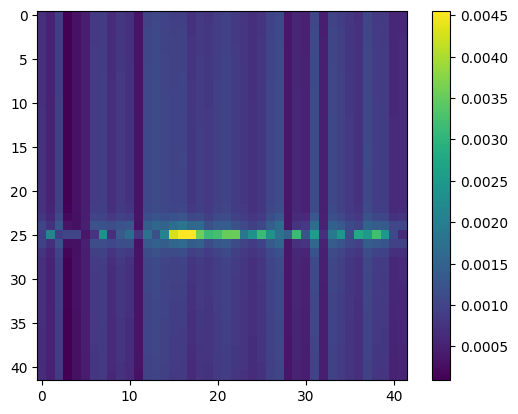

In [70]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]))
plt.colorbar()

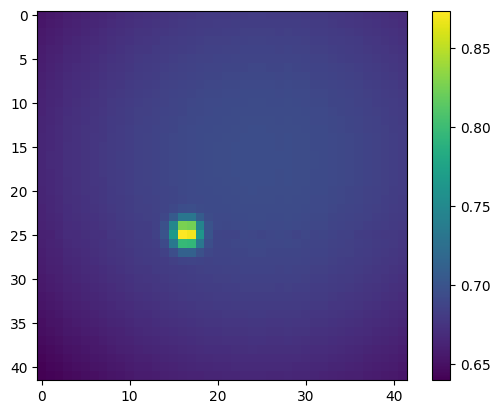

In [68]:
plt.imshow(test_model[-1])
plt.colorbar()

In [69]:
print(test_model[-1])

[[[0.6524158 ]
  [0.6545474 ]
  [0.65609515]
  ...
  [0.6705463 ]
  [0.6694215 ]
  [0.6679284 ]]

 [[0.65377206]
  [0.65592223]
  [0.6574842 ]
  ...
  [0.67205906]
  [0.6709228 ]
  [0.6694172 ]]

 [[0.6550611 ]
  [0.657229  ]
  [0.6588045 ]
  ...
  [0.67349696]
  [0.6723498 ]
  [0.6708323 ]]

 ...

 [[0.64293885]
  [0.64494044]
  [0.64638877]
  ...
  [0.65997577]
  [0.6589305 ]
  [0.65752536]]

 [[0.64120334]
  [0.6431811 ]
  [0.64461136]
  ...
  [0.65804005]
  [0.65700936]
  [0.65562034]]

 [[0.6394281 ]
  [0.6413816 ]
  [0.6427931 ]
  ...
  [0.65605986]
  [0.65504396]
  [0.6536715 ]]]
